# Storage

This notebook illustrates how simulations and results can be saved to file.

In [1]:
import pypesto
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
from pypesto.storage import (save_to_hdf5, read_from_hdf5)
import tempfile

%matplotlib inline

## Define the objective and problem

In [2]:
objective = pypesto.Objective(fun=sp.optimize.rosen, 
                              grad=sp.optimize.rosen_der, 
                              hess=sp.optimize.rosen_hess)

dim_full = 10
lb = -3 * np.ones((dim_full, 1))
ub = 3 * np.ones((dim_full, 1))

problem = pypesto.Problem(objective=objective, lb=lb, ub=ub)

# create optimizers
optimizer = pypesto.ScipyOptimizer(method='l-bfgs-b')

# set number of starts
n_starts = 20

## Objective function traces

During optimization, it is possible to regularly write the objective function trace to file. This is useful e.g. when runs fail, or for various diagnostics. Currently, pyPESTO can save histories to 3 backends: in-memory, as CSV files, or to HDF5 files.

### Memory History

To record the history in-memory, just set `trace_record=True` in the `pypesto.HistoryOptions`. Then, the optimization result contains those histories:

In [3]:
# record the history
history_options = pypesto.HistoryOptions(trace_record=True)

# Run optimizaitons
result = pypesto.minimize(
    problem=problem, optimizer=optimizer,
    n_starts=n_starts, history_options=history_options)

Now, in addition to queries on the result, we can also access the

History type:  <class 'pypesto.objective.history.MemoryHistory'>


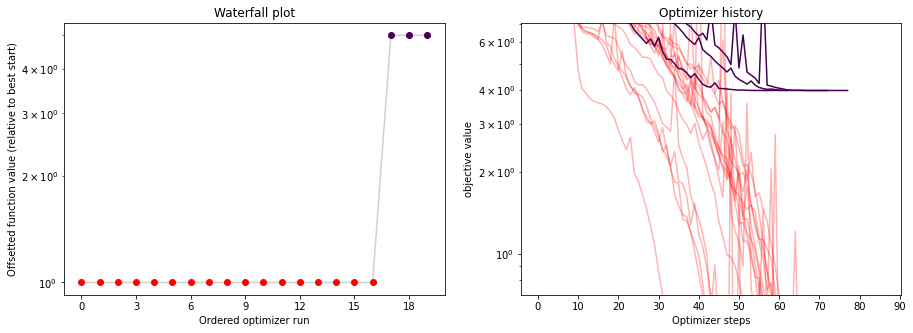

In [4]:
print("History type: ", type(result.optimize_result.list[0].history))
# print("Function value trace of best run: ", result.optimize_result.list[0].history.get_fval_trace())

fig, ax = plt.subplots(1, 2)
pypesto.visualize.waterfall(result, ax=ax[0])
pypesto.visualize.optimizer_history(result, ax=ax[1])
fig.set_size_inches((15, 5))

### CSV History

The in-memory storage is however not stored anywhere. To do that, it is possible to store either to CSV or HDF5. This is specified via the `storage_file` option. If it ends in `.csv`, a `pypesto.objective.history.CsvHistory` will be employed; if it ends in `.hdf5` a `pypesto.objective.history.Hdf5History`. Occurrences of the substring `{id}` in the filename are replaced by the multistart id, allowing to maintain a separate file per run (this is necessary for CSV as otherwise runs are overwritten).

In [5]:
# record the history and store to CSV
history_options = pypesto.HistoryOptions(trace_record=True, storage_file='history_{id}.csv')

# Run optimizaitons
result = pypesto.minimize(
    problem=problem, optimizer=optimizer,
    n_starts=n_starts, history_options=history_options)

Note that for this simple cost function, saving to CSV takes a considerable amount of time. This overhead decreases for more costly simulators, e.g. using ODE simulations via AMICI.

History type:  <class 'pypesto.objective.history.CsvHistory'>


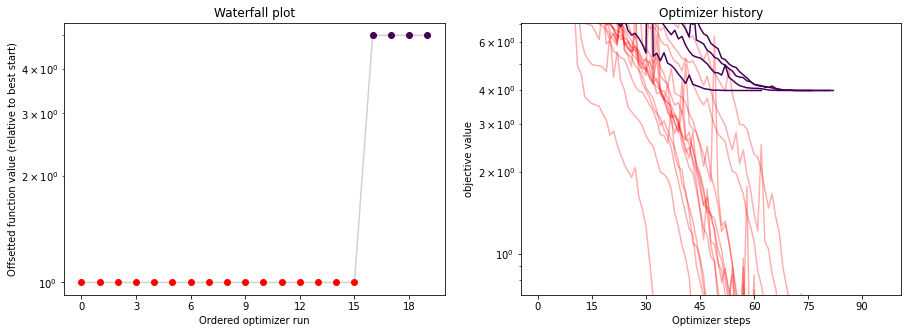

In [6]:
print("History type: ", type(result.optimize_result.list[0].history))
# print("Function value trace of best run: ", result.optimize_result.list[0].history.get_fval_trace())

fig, ax = plt.subplots(1, 2)
pypesto.visualize.waterfall(result, ax=ax[0])
pypesto.visualize.optimizer_history(result, ax=ax[1])
fig.set_size_inches((15, 5))

### HDF5 History

TODO: This is not fully implemented yet (it's on the way ...).

## Result storage

Result objects can be stored to HDF5 files. When appliable, this is preferable to just pickling results, which is not guaranteed to be reproducible in the future.

In [7]:
# Run optimizaitons
result = pypesto.minimize(
    problem=problem, optimizer=optimizer,
    n_starts=n_starts)

In [8]:
result.optimize_result.list[0:2]

[{'id': '16',
  'x': array([0.99999998, 0.99999999, 0.99999999, 1.00000002, 1.00000004,
         1.00000005, 1.00000011, 1.00000019, 1.00000041, 1.00000086]),
  'fval': 1.0840759188627262e-12,
  'grad': array([-1.54076893e-05,  4.88166217e-06, -1.27059470e-05,  6.96391071e-06,
          1.48065820e-05, -1.19529462e-05,  1.62532245e-05, -1.91045260e-05,
         -1.18540309e-05,  9.49378891e-06]),
  'hess': None,
  'res': None,
  'sres': None,
  'n_fval': 68,
  'n_grad': 68,
  'n_hess': 0,
  'n_res': 0,
  'n_sres': 0,
  'x0': array([-2.06905833, -0.19206942, -1.72867234, -2.33804033, -0.71061311,
         -2.98146846, -1.10208315, -0.02865718,  2.40969018, -2.71535605]),
  'fval0': 28216.041116743356,
  'history': <pypesto.objective.history.History at 0x7faa1d10ee90>,
  'exitflag': 0,
  'time': 0.017784595489501953,
  'message': b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'},
 {'id': '18',
  'x': array([0.99999998, 0.99999997, 1.00000004, 1.00000003, 1.00000008,
         1.00000005

As usual, having obtained our result, we can directly perform some plots:

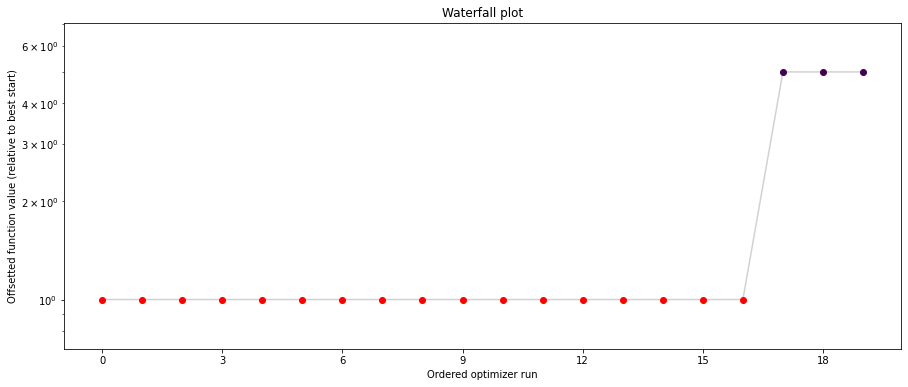

In [9]:
import pypesto.visualize

# plot waterfalls
pypesto.visualize.waterfall(result, size=(15,6))

### Save optimization result as HDF5 file

The optimization result can be saved via a `pypesto.OptimizationResultHDF5Writer`.

In [10]:
fn = tempfile.mktemp(".hdf5")

# Write result
hdf5_writer = save_to_hdf5.OptimizationResultHDF5Writer(fn)
hdf5_writer.write(result)

# Write problem
hdf5_writer = save_to_hdf5.ProblemHDF5Writer(fn)
hdf5_writer.write(problem)

### Read optimization result from HDF5 file

When reading in the stored result again, we recover the original optimization result:

In [11]:
# Read result and problem
hdf5_reader = read_from_hdf5.OptimizationResultHDF5Reader(fn)
result = hdf5_reader.read()

In [12]:
result.optimize_result.list[0:2]

[{'id': '16',
  'x': array([0.99999998, 0.99999999, 0.99999999, 1.00000002, 1.00000004,
         1.00000005, 1.00000011, 1.00000019, 1.00000041, 1.00000086]),
  'fval': 1.0840759188627262e-12,
  'grad': array([-1.54076893e-05,  4.88166217e-06, -1.27059470e-05,  6.96391071e-06,
          1.48065820e-05, -1.19529462e-05,  1.62532245e-05, -1.91045260e-05,
         -1.18540309e-05,  9.49378891e-06]),
  'hess': None,
  'res': None,
  'sres': None,
  'n_fval': 68,
  'n_grad': 68,
  'n_hess': 0,
  'n_res': 0,
  'n_sres': 0,
  'x0': array([-2.06905833, -0.19206942, -1.72867234, -2.33804033, -0.71061311,
         -2.98146846, -1.10208315, -0.02865718,  2.40969018, -2.71535605]),
  'fval0': 28216.041116743356,
  'history': None,
  'exitflag': 0,
  'time': 0.017784595489501953,
  'message': b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'},
 {'id': '18',
  'x': array([0.99999998, 0.99999997, 1.00000004, 1.00000003, 1.00000008,
         1.00000005, 1.00000001, 1.00000002, 1.00000016, 1.00000028]

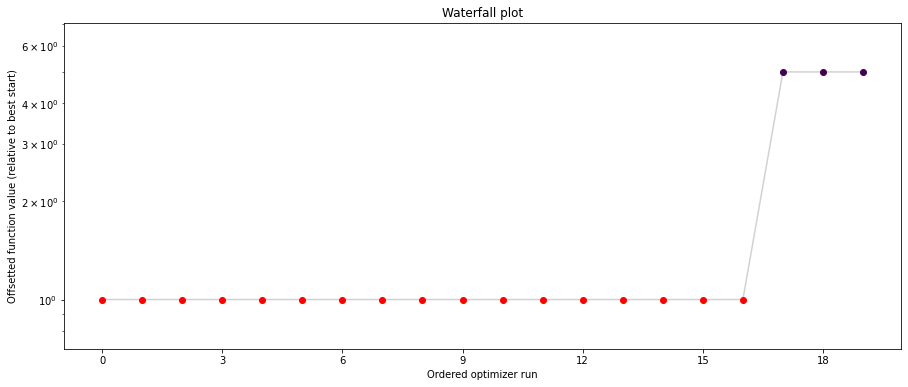

In [13]:
# plot waterfalls
pypesto.visualize.waterfall(result, size=(15,6))